In [1]:
from datascience import *
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

import warnings
warnings.simplefilter("ignore")

# Lecture 28

## `ckd` data

In [3]:
ckd = Table.read_table('ckd.csv')
ckd = ckd.relabeled('Blood Glucose Random', 'Glucose')
ckd = ckd.select('Glucose', 'Hemoglobin', 'White Blood Cell Count', 'Class')

Glucose,Hemoglobin,White Blood Cell Count,Class
117,11.2,6700,1
70,9.5,12100,1
380,10.8,4500,1


## `breast-cancer` data (Google Science Fair)

In [5]:
patients = Table.read_table('breast-cancer.csv').drop('ID')
patients.show(5)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,1,1,1,2,1,3,1,1,0
5,4,4,5,7,10,3,2,1,0
3,1,1,1,2,2,3,1,1,0
6,8,8,1,3,4,3,7,1,0
4,1,1,3,2,1,3,1,1,0


In [6]:
patients.group('Class')

Class,count
0,444
1,239


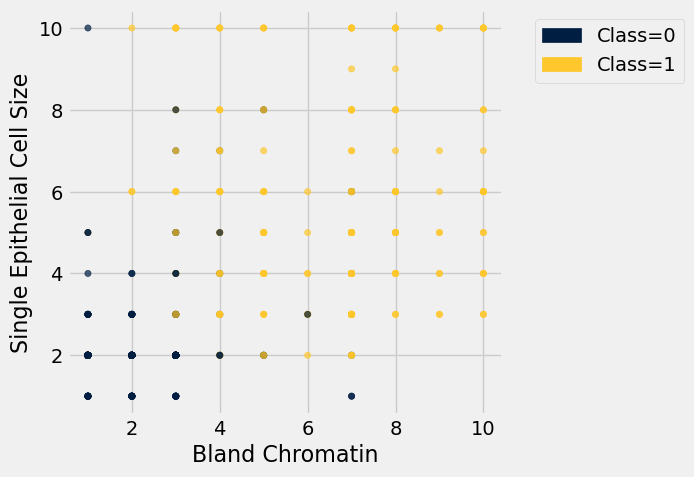

In [7]:
patients.scatter('Bland Chromatin', 'Single Epithelial Cell Size', group='Class')

**Handling overplotting issues by "jittering" the points**

In [4]:
patients = Table.read_table('breast-cancer.csv').drop('ID')

def randomize_column(a):
    return a + np.random.normal(0.0, 0.09, size=len(a))

jittered = Table().with_columns([
        'Bland Chromatin (jittered)', 
        randomize_column(patients.column('Bland Chromatin')),
        'Single Epithelial Cell Size (jittered)', 
        randomize_column(patients.column('Single Epithelial Cell Size')),
        'Class',
        patients.column('Class')
    ])

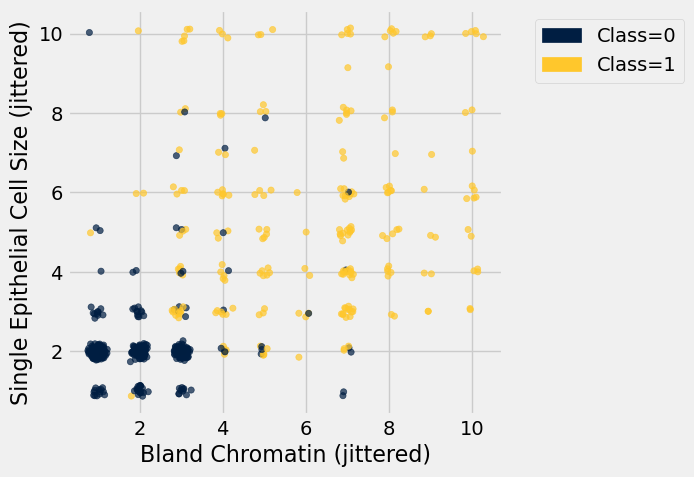

In [8]:
jittered.scatter(0, 1, group='Class')

**STOP**

## Building the classifer (review)

In [9]:
def distance(pt1, pt2):
    """Return the distance between two points, represented as arrays"""
    return np.sqrt(sum((pt1 - pt2)**2))

In [10]:
def row_distance(row1, row2):
    """Return the distance between two numerical rows of a table"""
    return distance(np.array(row1), np.array(row2))

In [12]:
def distances(training, example):
    """
    Compute distance between example and every row in training.
    Return training augmented with Distance column
    """
    distances = make_array()
    attributes_only = training.drop('Class')
    
    for row in attributes_only.rows:
        distances = np.append(distances, row_distance(row, example))
    
#   ^ SAME AS DOING:
#
#   for i in np.arange(attributes_only.num_rows):
#       row = attributes_only.row(i)
#       distances = np.append(distances, row_distance(row, example))
        
    return training.with_column('Distance_to_ex', distances)

In [11]:
def closest(training, example, k):
    """
    Return a table of the k closest neighbors to example
    """
    return distances(training, example).sort('Distance_to_ex').take(np.arange(k))

In [13]:
def majority_class(topk):
    """
    Return the class with the highest count
    """
    return topk.group('Class').sort('count', descending=True).column(0).item(0)

In [14]:
def classify(training, example, k):
    """
    Return the majority class among the 
    k nearest neighbors of example
    """
    return majority_class(closest(training, example, k))

### Review of the Steps 

- `distance(pt1, pt2)`: Returns the distance between the arrays `pt1` and `pt2`
- `row_distance(row1, row2)`: Returns the distance between the rows `row1` and `row2`
- `distances(training, example)`: Returns a table that is `training` with an additional column `'Distance'` that contains the distance between `example` and each row of `training`
- `closest(training, example, k)`: Returns a table of the rows corresponding to the k smallest distances 
- `majority_class(topk)`: Returns the majority class in the `'Class'` column
- `classify(training, example, k)`: Returns the predicted class of `example` based on a `k` nearest neighbors classifier using the historical sample `training`

## Using the classifer and determining its accuracy

### Train and test split

In [16]:
patients.num_rows

683

In [18]:
shuffled = patients.sample(with_replacement=False) 
training_set = shuffled.take(np.arange(342))
test_set  = shuffled.take(np.arange(342, 683))

### Classifying individual points

In [21]:
test_set.take(0)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
1,1,1,1,2,1,1,1,1,0


In [27]:
classify(training_set, test_set.drop('Class').row(0), 5)

0

In [30]:
test_set.take(34)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
8,3,4,9,3,10,3,3,1,1


In [31]:
classify(training_set, test_set.drop('Class').row(34), 5)

1

### Classifying all the points at once and returning an accuracy rate

In [32]:
def evaluate_accuracy(training, test, k):
    """Return the proportion of correctly classified examples 
    in the test set"""
    test_attributes = test.drop('Class')
    num_correct = 0
    for i in np.arange(test.num_rows):
        c = classify(training, test_attributes.row(i), k)
        num_correct = num_correct + (c == test.column('Class').item(i))
    return num_correct / test.num_rows

**This code will take a little longer to run.**

In [33]:
evaluate_accuracy(training_set, test_set, 1)

0.9442815249266863

In [34]:
evaluate_accuracy(training_set, test_set, 3)

0.9618768328445748

In [35]:
evaluate_accuracy(training_set, test_set, 5)

0.9589442815249267

In [36]:
evaluate_accuracy(training_set, test_set, 7)

0.9560117302052786

In [37]:
evaluate_accuracy(training_set, test_set, 9)

0.9530791788856305

In [38]:
evaluate_accuracy(training_set, test_set, 11)

0.9501466275659824

**STOP**

### Standardize if necessary

In [39]:
def standard_units(x):
    return (x - np.average(x)) / np.std(x)

In [41]:
ckd_new = ckd.select('Class').with_columns(
    'Glucose_su', standard_units(ckd.column('Glucose')),
    'Hemoglobin_su', standard_units(ckd.column('Hemoglobin')),
    'WBC_su', standard_units(ckd.column('White Blood Cell Count'))
)

In [43]:
shuffled = ckd_new.sample(with_replacement=False) 
training_set = shuffled.take(np.arange(74))
test_set  = shuffled.take(np.arange(74, 148))

evaluate_accuracy(training_set, test_set, 3)

1.0

In [45]:
shuffled = ckd.sample(with_replacement=False) 
training_set = shuffled.take(np.arange(74))
test_set  = shuffled.take(np.arange(74, 148))

evaluate_accuracy(training_set, test_set, 3)

0.8378378378378378